### Analyze some fancier properties of ArtEmis and compare it (optionally) with other common datasets.
    - Concreteness, 
    - Subjectivity based on TextBlob 
    - Sentimenet-Analysis based on (nltk) Vader
    - The above metrics on ArtEmis per art-gerne 
    - Parts-Of-Speech

* Note. Please contact optas@stanford for the files corresponding to the other datasets if you do not have access to them. I will streamline this in April. 

In [50]:
import json
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from collections import Counter
from functools import partial
from ast import literal_eval
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from artemis.utils.basic import df_parallel_column_apply
from artemis.analysis.utils import contains_word, contains_bigrams, concreteness_of_sentence, pos_analysis
from artemis.language.basics import tokenize_and_spell, ngrams
from artemis.language.part_of_speech import nltk_parallel_tagging_of_tokens
from artemis.utils.visualization import plot_overlayed_two_histograms
from artemis.utils.other_datasets.flickr30K_entities import load_all_linguistic_annotations
from artemis.utils.other_datasets.conceptual_captions import load_conceptual_captions
from artemis.utils.other_datasets.google_refexp import load_google_refexp_captions

sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
try:
    from textblob import TextBlob    
except:
    print('For analyzing the subjectivity (bottom parts of notebook) you need to install textblob')  
    print('e.g., conda install -c conda-forge textblob')

In [5]:
freq_file = '../../data/symspell_frequency_dictionary_en_82_765.txt'
glove_file = '../../data/glove.6B.100d.vocabulary.txt'

## Use your path:
artemis_preprocessed_csv = '/home/optas/DATA/OUT/artemis/preprocessed_data/for_analysis/artemis_preprocessed.csv'

In [6]:
##
## For the following files send to me an email (optas@stanford.edu) 
## (or git-pull on April 7) P.s. they are available online
##
brm_file=\
'/home/optas/DATA/Language/sentiment_psychology/abstractness_BRM/Concreteness_ratings_Brysbaert_et_al_BRM.xlsx'

coco_file=\
'/home/optas/DATA/OUT/ela/coco_related/coco2014_captions.csv'

flickr_dir=\
'/home/optas/DATA/Language/flickr30Kentities/annotations/Sentences/'

conceptual_caps_train=\
'/home/optas/DATA/Language/conceptual_captions/Train_GCC-training.tsv'

conceptual_caps_val=\
'/home/optas/DATA/Language/conceptual_captions/Validation_GCC-1.1.0-Validation.tsv'

google_refexp_train=\
'/home/optas/DATA/Language/google_refexp/google_refexp_train_201511.json'

google_refexp_val=\
'/home/optas/DATA/Language/google_refexp/google_refexp_val_201511.json'

In [7]:
##
## Hyper-params for notebook 
##
load_ela = True
load_coco = True

load_flickr = False  # if turn on, it will also load/contrast with this datatasets.
load_concept_caps = False
load_google_refexp = False

brm_drop_articles = True # use or not the: "the", "a", "an", "every".
spell_check_non_artemis_data = False

In [9]:
### Load -datasets-
datasets = dict()
if load_ela:
    df = pd.read_csv(artemis_preprocessed_csv)
    df.tokens = df.tokens.apply(literal_eval)
    datasets['ArtEmis'] = df
    

if load_coco:        
    df = pd.read_csv(coco_file)
    coco_missed_tokens = tokenize_and_spell(df, glove_file, freq_file, 
                                            nltk.word_tokenize, spell_check=spell_check_non_artemis_data)
    datasets['COCO'] = df
    

if load_flickr:
    df = load_all_linguistic_annotations(flickr_dir)    
    coco_missed_tokens = tokenize_and_spell(df, glove_file, freq_file, 
                                            nltk.word_tokenize, spell_check=spell_check_non_artemis_data)
    datasets['Flickr'] = df
    
    
if load_concept_caps:    
    ## Quick and Dirty
    df = load_conceptual_captions(conceptual_caps_train, conceptual_caps_val, only_language=True)
    cc_missed_tokens = tokenize_and_spell(df, glove_file, freq_file, 
                                          nltk.word_tokenize, spell_check=spell_check_non_artemis_data)
    datasets['ConceptualCaptions'] = df
    
    
if load_google_refexp:
    df = load_google_refexp_captions(google_refexp_train, google_refexp_val)
    refexp_missed_tokens = tokenize_and_spell(df, glove_file, freq_file, 
                                              nltk.word_tokenize, spell_check=spell_check_non_artemis_data)
    datasets['GoogleRefxp'] = df

SymSpell spell-checker loaded: True
Loading glove word embeddings.
Done. 400000 words loaded.
Updating Glove vocabulary with *valid* ArtEmis words that are missing from it.


In [10]:
for k, v in datasets.items():
    print(k, 'N-sentences:', len(v), 'Average Length:', v.tokens_len.mean().round(1))

ArtEmis N-sentences: 454684 Average Length: 15.9
COCO N-sentences: 616767 Average Length: 10.5


In [10]:
##
## Conreteness Analysis
##

In [11]:
#
# Load "concreteness and abstractness" values
#

## Note. If your pandas cannot read excel do:
## else:  pip install xlrd==1.2.0

brm_data = pd.read_excel(brm_file)
brm_data.Word = brm_data.Word.apply(lambda x: str(x).lower())

if brm_drop_articles:
    brm_data = brm_data[brm_data.Dom_Pos != 'Article']
    
brm_data = brm_data[['Word', 'Conc.M']]
brm_data.columns = ['word', 'concreteness']
word_to_concreteness = dict(zip(brm_data.word, brm_data.concreteness))

In [26]:
concreteness_scores = dict()
for dset_name in datasets:    
    concreteness_scores[dset_name] = datasets[dset_name].tokens.apply(lambda x: concreteness_of_sentence(x, word_to_concreteness))    
    smean = concreteness_scores[dset_name].mean().round(2)
    smedian = concreteness_scores[dset_name].median().round(2)
    print(dset_name, 'concreteness', smean, smedian)

ArtEmis concreteness 2.81 2.78
COCO concreteness 3.55 3.57


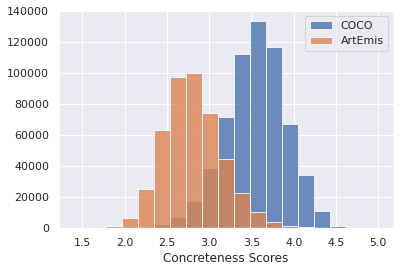

In [27]:
x1 = concreteness_scores['ArtEmis'][~concreteness_scores['ArtEmis'].isna()]
x2 = concreteness_scores['COCO'][~concreteness_scores['COCO'].isna()]

fig = plot_overlayed_two_histograms(x2, x1, min_val=1.4, max_val=5.0, 
                                    n_bins=20, alpha=0.8, labels=['COCO', 'ArtEmis']);

fig.axes[0].set_xlabel('Concreteness Scores')
fig.savefig('ArtEmis_vs_COCO_concreteness.jpg')

In [28]:
x1.median(), x2.median()

(2.784166666666667, 3.5657142857142854)

In [55]:
# restrict to the most abstract words, bigrams (per percentile value). How many of those are precent in eaach dataset?
wc_vals = list(word_to_concreteness.values())
prc = 1
conc_threshold = np.percentile(wc_vals, prc)
abstract_unigrams = set()
abstract_bigrams = set()
for k, v in word_to_concreteness.items():
    if v <= conc_threshold:
        if ' ' in k:
            abstract_bigrams.add(k)
        else:
            abstract_unigrams.add(k)            

print('Percentile of most abstract:', prc)
print('Number of words/bigrams to be used as abstract:', len(abstract_unigrams), len(abstract_bigrams))

uses_abstract = contains_word(datasets['ArtEmis'].tokens, abstract_unigrams)
uses_abstract |= datasets['ArtEmis'].tokens.apply(partial(contains_bigrams, abstract_bigrams))
print(uses_abstract.mean())

uses_abstract = contains_word(datasets['COCO'].tokens, abstract_unigrams)
uses_abstract |= datasets['COCO'].tokens.apply(partial(contains_bigrams, abstract_bigrams))
print(uses_abstract.mean())

Percentile of most abstract: 1
Number of words/bigrams to be used as abstract: 424 4
0.31532448909572364
0.026355171401842188


In [29]:
##
## Sentiment Analysis
##

In [35]:
def vader_classify(score, threshold=0.05):
    if abs(score) < threshold:
        return 'neutral'

    if score > 0:
        return 'positive'

    if score < 0:
        return 'negative'
    
def vader_score(sentence):
    return vader.polarity_scores(sentence)['compound']

In [31]:
sentiment_scores = dict()
vader = SentimentIntensityAnalyzer()

In [32]:
for dset_name in datasets:    
    sentiment_scores[dset_name] = datasets[dset_name]['utterance_spelled'].apply(lambda x: vader.polarity_scores(x)['compound'])
    scores = sentiment_scores[dset_name]
    smean = scores.abs().mean().round(2)
    smedian = scores.abs().median().round(2)    
    print(dset_name, 'sentiment-score', smean, smedian)

ArtEmis sentiment-score 0.44 0.46
COCO sentiment-score 0.07 0.0


In [36]:
sentiment_classes_list = []  # aggregate for all datasets to make a nice plot
dataset_names = []
sentiment_classes = dict()
threshold = 0.05
for name in sentiment_scores:
    temp = sentiment_scores[name].apply(lambda x: vader_classify(x, threshold=threshold))
    sentiment_classes[name] = temp    
    sentiment_classes_list.extend(temp.to_list())
    dataset_names.extend(len(temp) * [name])    

In [37]:
for name in sentiment_classes:
    print(name, (sentiment_classes[name] == 'neutral').mean())

ArtEmis 0.164558242647641
COCO 0.7744512919789808


In [38]:
d1 = pd.DataFrame(dataset_names, columns=['dataset'])
d2 = pd.DataFrame(sentiment_classes_list, columns=['sentiment-class'])
aggregate_sentiment_stats = pd.concat([d1, d2], axis=1)

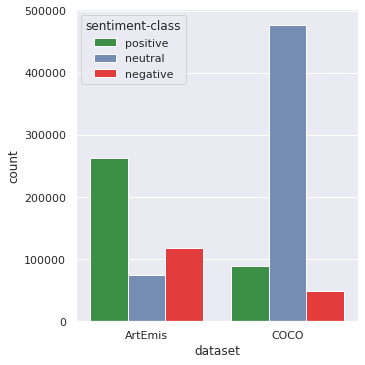

In [39]:
c = sns.catplot(x="dataset", 
                hue="sentiment-class", 
                data=aggregate_sentiment_stats, 
                kind="count",                 
                palette={"negative": "#FE2020", 
                         "positive": "#2f9c3b", 
                         "neutral": "#6b8abd"},                                
                legend_out=False,
               )
c.savefig('ArtEmis_vs_COCO_sentiment_classes.jpg')

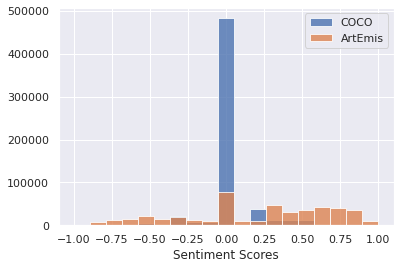

In [40]:
fig= plot_overlayed_two_histograms(sentiment_scores['COCO'], 
                              sentiment_scores['ArtEmis'], 
                              min_val=-1, max_val=1, n_bins=20, labels=['COCO', 'ArtEmis']);
fig.axes[0].set_xlabel('Sentiment Scores')
fig.savefig('ArtEmis_vs_COCO_sentiment_scores.jpg')

In [ ]:
##
## Subjectivity Analysis
##

In [12]:
def subjectivity(utterance):
    testimonial = TextBlob(utterance)
    return testimonial.sentiment.subjectivity

In [13]:
print(TextBlob('The painting is red').sentiment.subjectivity)
print(TextBlob('The painting is nice').sentiment.subjectivity)

0.0
1.0


In [15]:
subjectivity_scores = dict()
for dset_name in datasets:    
    subjectivity_scores[dset_name] = df_parallel_column_apply(datasets[dset_name], subjectivity, 'utterance_spelled')

In [16]:
print(subjectivity_scores['COCO'].mean().round(2))
print(subjectivity_scores['COCO'].median().round(2))

print(subjectivity_scores['ArtEmis'].mean().round(2))
print(subjectivity_scores['ArtEmis'].median().round(2))

0.19
0.02
0.47
0.5


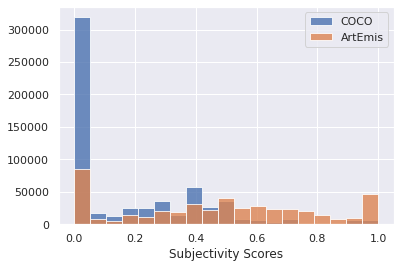

In [17]:
fig = plot_overlayed_two_histograms(subjectivity_scores['COCO'], 
                              subjectivity_scores['ArtEmis'], 
                              min_val=0, max_val=1, n_bins=20, labels=['COCO', 'ArtEmis']);
fig.axes[0].set_xlabel('Subjectivity Scores')
fig.savefig('ArtEmis_vs_COCO_subjectivity_scores.jpg')

In [18]:
##
## Analyze the above metric per art-genre
##

In [44]:
name = 'ArtEmis'
datasets[name]['conreteness_scores'] = concreteness_scores[name]    
datasets[name]['subjectivity_scores'] = subjectivity_scores[name]
datasets[name]['sentiment_abs_scores'] = sentiment_scores[name].abs()

In [45]:
g = pd.read_csv('../../data/wiki_art_genre_class.csv')
m = pd.merge(datasets['ArtEmis'], g, on=['art_style', 'painting'])

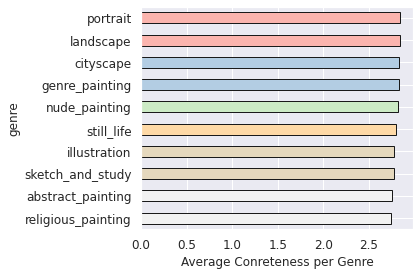

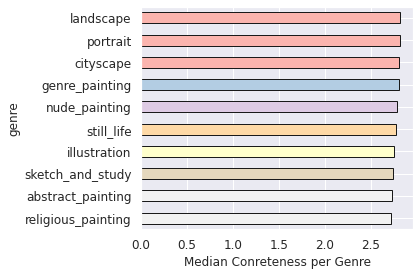

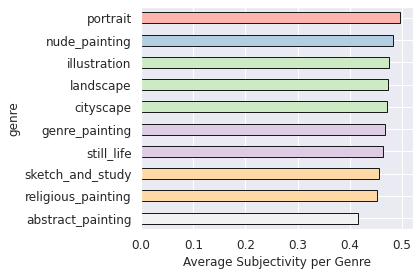

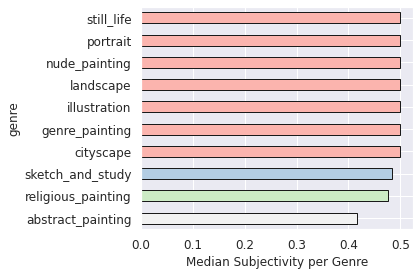

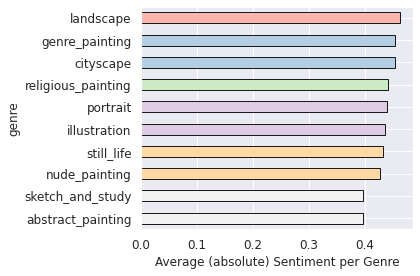

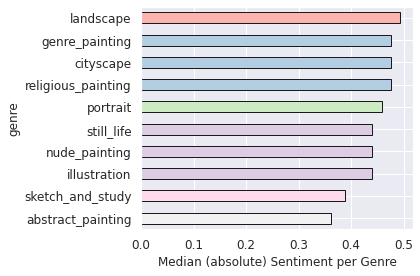

In [46]:
pallete = plt.cm.Pastel1_r

for metric in ['conreteness_scores', 'subjectivity_scores', 'sentiment_abs_scores']:
    for stat in ['average', 'median']:
        
        if stat == 'average':
            s = m.groupby('genre')[metric].mean().sort_values()
        else:
            s = m.groupby('genre')[metric].median().sort_values()
            
        fig = plt.figure()
        norm = plt.Normalize(s.min(), s.max())
        colors = pallete(norm(s.values))                
        ax = s.plot.barh(grid=True, color=colors, ec="k", fontsize=12)        

        name_of_metric = metric.split('_')[0].capitalize()
        
        if metric == 'sentiment_abs_scores':                        
            xlabel = '{} (absolute) Sentiment per Genre'.format(stat.capitalize())
        else:            
            xlabel = '{} {} per Genre'.format(stat.capitalize(), name_of_metric)        
        
        ax.set_xlabel(xlabel)
        plt.tight_layout()        
        fig.savefig('ArtEmis_{}_per_Genre_{}.jpg'.format(name_of_metric, stat.capitalize()))

In [47]:
##
## Analyze basic linguistic elements: Part-Of-Speech
##

In [48]:
for df in datasets.values():
    df['pos'] = nltk_parallel_tagging_of_tokens(df.tokens)

In [51]:
# (raw numbers of Table.1 in main papeer)
for dataset_name, df in datasets.items():
    print(dataset_name)
    pos_analysis(df)

ArtEmis
Nouns 4.0
Pronouns 0.9
Adjectives 1.6
Adpositions 1.9
Verbs 3.0
COCO
Nouns 3.7
Pronouns 0.1
Adjectives 0.8
Adpositions 1.7
Verbs 1.2


In [ ]:
# Below group the utterances first along each image (stimulus).
# Numbers of Table.2 in main paper

In [53]:
pos_analysis(datasets['ArtEmis'], group_cols=['painting', 'art_style'])

  0%|          | 0/80031 [00:00<?, ?it/s]

Nouns 18.7 3.4
Pronouns 3.1 0.6
Adjectives 8.3 1.5
Adpositions 6.5 1.2
Verbs 13.4 2.4


In [174]:
pos_analysis(datasets['GoogleRefxp'], group_cols=['image_id'])


Nouns 7.8 2.2
Pronouns 0.4 0.1
Adjectives 2.8 0.8
Adpositions 2.9 0.8
Verbs 2.3 0.6


In [52]:
pos_analysis(datasets['COCO'], group_cols=['image'])

  0%|          | 0/123287 [00:00<?, ?it/s]

Nouns 10.8 2.2
Pronouns 0.6 0.1
Adjectives 3.3 0.7
Adpositions 4.5 0.9
Verbs 4.5 0.9


In [150]:
pos_analysis(datasets['Flickr'], group_cols=['image_id'])


Nouns 12.9 2.6
Pronouns 0.8 0.2
Adjectives 4.0 0.8
Adpositions 4.9 1.0
Verbs 6.4 1.3
